# Getting Started
Let's walk through an example application of Geometricus in machine learning using a dataset of
human MAP kinases, divided into three classes - JNK, Erk, and p38 kinases. This dataset was generated from
the [Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS)](https://klifs.vu-compmedchem.nl/index.php).

In [1]:
import pandas as pnd
from pathlib import Path

data_dir = Path("../../example_data")
mapk_df = pnd.read_csv(data_dir / "MAPK_KLIFS.tsv", sep="\t")
mapk_df.head()

,FAMILY,GROUPS,PDB,CHAIN,ALTERNATE_MODEL,SPECIES,LIGAND,PDB_IDENTIFIER,ALLOSTERIC_NAME,ALLOSTERIC_PDB,DFG,AC_HELIX,CLASS
MAPK8 (JNK1),MAPK,CMGC,3o2m,A,-,Human,-,-,"N-butyl-4,6-dimethyl-N-{[2&apos;-(2H-tetrazol-...",46A,in,in,JNK
MAPK8 (JNK1),MAPK,CMGC,3o2m,B,-,Human,-,-,"N-butyl-4,6-dimethyl-N-{[2&apos;-(2H-tetrazol-...",46A,in,in,JNK
MAPK14 (p38a),MAPK,CMGC,4eh8,A,A,Human,[3-(benzyloxy)phenyl]methanol,0OP,"N~4~-cyclopropyl-2-phenylquinazoline-4,7-diamine",IRG,in,out,p38
MAPK14 (p38a),MAPK,CMGC,4eh2,A,-,Human,3-phenylquinazolin-4(3H)-one,0OK,"N~4~-cyclopropyl-2-phenylquinazoline-4,7-diamine",IRG,in,out-like,p38
MAPK14 (p38a),MAPK,CMGC,4eh7,A,A,Human,(3-phenoxyphenyl)methanol,0OO,"N~4~-cyclopropyl-2-phenylquinazoline-4,7-diamine",IRG,na,na,p38


In [2]:
mapk_pdb_to_class = {}
for pdb, chain, class_name in list(zip(mapk_df["PDB"], mapk_df["CHAIN"], mapk_df["CLASS"])):
    mapk_pdb_to_class[(pdb, chain)] = class_name

So now we have a list of (PDB ID, chain) pairs, each associated with a class

In [3]:
X_names = list(mapk_pdb_to_class.keys())
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
y = [class_mapping[mapk_pdb_to_class[k]] for k in X_names]

### Structural fragmentation
We consider two different ways of dividing a protein with $l$ residues into structural fragments,
using its $\alpha$-carbon coordinates, $\mathbf{\alpha} = \{ \mathbf{\alpha_i} | \mathbf{\alpha_i} = (\alpha_i^x, \alpha_i^y, \alpha_i^z), i : 1, ..., l \}$.
1. _$\mathbf{k}$-mer-based_ - for a given value of $k$, a protein is divided into $l$ $k$-mer-based structural fragments, $\{ C^k_i, i : 1, ..., l \}$ where

$$C^k_i = \{ \mathbf{\alpha_j} | j \in (\max(1, i-\lfloor{k/2}\rfloor), \min(l, i + \lfloor{k/2}\rfloor)) \}$$

2. _radius-based_ - for a given radius $r$, a protein is divided into $l$ radius-based structural fragments $\{ C^r_i, i : 1, ..., l \}$ where

$$C^r_i = \{ \mathbf{\alpha_j} | d(\mathbf{\alpha_i}, \mathbf{\alpha_j}) < r \}$$

with $d(\mathbf{\alpha_i}, \mathbf{\alpha_j}) $ being the Euclidean distance between $\mathbf{\alpha_i}$ and $\mathbf{\alpha_j}$.

For each structural fragment, four rotation and translation-invariant moments are calculated, termed $O_1, O_2, O_3$, and $O_4$.

While the $k$-mer based approach is effective in describing structural fragments that are sequential in nature, such as $\alpha$-helices and loops,
the radius-based approach can capture long-range structural contacts as seen in $\beta$-sheets, as well as distinct interaction patterns in space,
as found in enzyme active sites.

Below we load a pickle file containing pre-parsed proteins stored as ProDy AtomGroup objects.
This can also be done directly from PDB files by replacing the `geometricus.MomentInvariants.from_prody_atomgroup` call by
 `geometricus.MomentInvariants.from_pdb_file(pdb_file, chain=chain, ...)` or even `from_pdb_id(pdb_id, chain=chain, ...)` to download from RCSB via FTP.

In [4]:
from geometricus import geometricus
import pickle
from time import time

invariants_kmer = {}
invariants_radius = {}
with open(data_dir / "atomgroups.pkl", "rb") as f:
    key_to_atomgroup = pickle.load(f)

start_time = time()
for i, key in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {round(time() - start_time, 2)} seconds")
    invariants_kmer[key] = geometricus.MomentInvariants.from_prody_atomgroup(key, key_to_atomgroup[key], split_type="kmer", split_size=16)
    invariants_radius[key] = geometricus.MomentInvariants.from_prody_atomgroup(key, key_to_atomgroup[key], split_type="radius", split_size=10)

50 proteins in 4.49 seconds
100 proteins in 7.85 seconds
150 proteins in 10.79 seconds
200 proteins in 15.11 seconds
250 proteins in 18.25 seconds
300 proteins in 21.33 seconds
350 proteins in 24.27 seconds
400 proteins in 27.33 seconds
450 proteins in 30.3 seconds
500 proteins in 33.29 seconds


### Generating an Embedding from Structural Fragments
Moment invariants are discretized into shape-mers using the below formula,
where $m$ is the resolution parameter controlling how coarse or fine-grained this discretization is.

\begin{equation*}
  \begin{aligned}
    (O_3', O_4', O_5', F') = (\lfloor{m \times\ln(O_3)}\rfloor,  \lfloor{m \times \ln(O_4)}\rfloor,  \\
    \lfloor{m \times \ln(O_5)}\rfloor,  \lfloor{m \times \ln(F)}\rfloor)
  \end{aligned}
\end{equation*}

Given a set of $n$ proteins, we generate a collection of shape-mers for each protein. The total number of shape-mers $s$ is then the number of
distinct shape-mers observed across all $n$ proteins. A count vector of length $s$ is calculated for each protein with each element recording the
number of times the corresponding shape-mer appears in that protein. This counting is done separately for the $k$-mer and radius based approaches,
as they represent different types of structural fragments. The two resulting count vectors are concatenated to form the final protein embedding.

### Embedding for Dimensionality Reduction
Embeddings across all proteins can be used for dimensionality reduction and visualization.

Generated embedding in 2.57 seconds


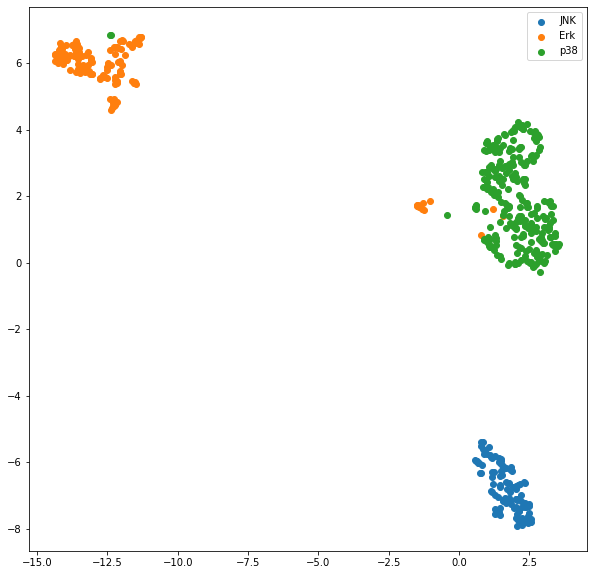

In [9]:
import umap
import numpy as np
import matplotlib.pyplot as plt

start_time = time()
embedder = geometricus.GeometricusEmbedding(invariants_kmer, invariants_radius, resolution=2., protein_keys=X_names)
print(f"Generated embedding in {round(time() - start_time, 2)} seconds")

reducer = umap.UMAP(metric="cosine", n_components=2)
reduced = reducer.fit_transform(embedder.embedding)

class_names = ["JNK", "Erk", "p38"]
colors = ["red", "green", "blue"]
plt.figure(figsize=(10,10))
for i in range(3):
    indices = np.where(np.array(y) == i)[0]
    plt.scatter(reduced[indices, 0],
                reduced[indices, 1],
                label=class_names[i])
plt.legend();

### Embedding for Supervised Learning
Supervised learning, be it classification or regression, requires some form of training and test sets.
The shape-mers used in embedding are calculated from the training set and only those shape-mers are counted in the test set.

In [6]:
from sklearn.model_selection import train_test_split

X_train_names, X_test_names, y_train, y_test = train_test_split(X_names, y, test_size=0.3)

train_embedder = geometricus.GeometricusEmbedding(invariants_kmer, invariants_radius, resolution=2.,
                                                  protein_keys=X_train_names)
test_embedder = geometricus.GeometricusEmbedding(invariants_kmer, invariants_radius, resolution=2.,
                                                 protein_keys=X_test_names,
                                                 kmer_shape_keys=train_embedder.kmer_shape_keys,
                                                 radius_shape_keys=train_embedder.radius_shape_keys,
)
X_train, X_test = train_embedder.embedding, test_embedder.embedding


              precision    recall  f1-score   support

         JNK       0.82      0.97      0.89        29
         Erk       1.00      0.94      0.97        49
         p38       0.96      0.94      0.95        81

    accuracy                           0.94       159
   macro avg       0.93      0.95      0.94       159
weighted avg       0.95      0.94      0.94       159



For this simple problem, a decision tree classifier is more than enough to obtain good accuracy.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, [0, 1, 2], class_names))

### Interpretation of predictive residues / shapes
Since each shape-mer can be mapped back to the residues it describes, it is easy to use Geometricus to determine predictive or functionally relevant
residues and structural regions. Such insights can be directly be applied to select candidate residues for mutational studies or used in directed 
evolution techniques to engineer proteins and enzymes with desired properties.

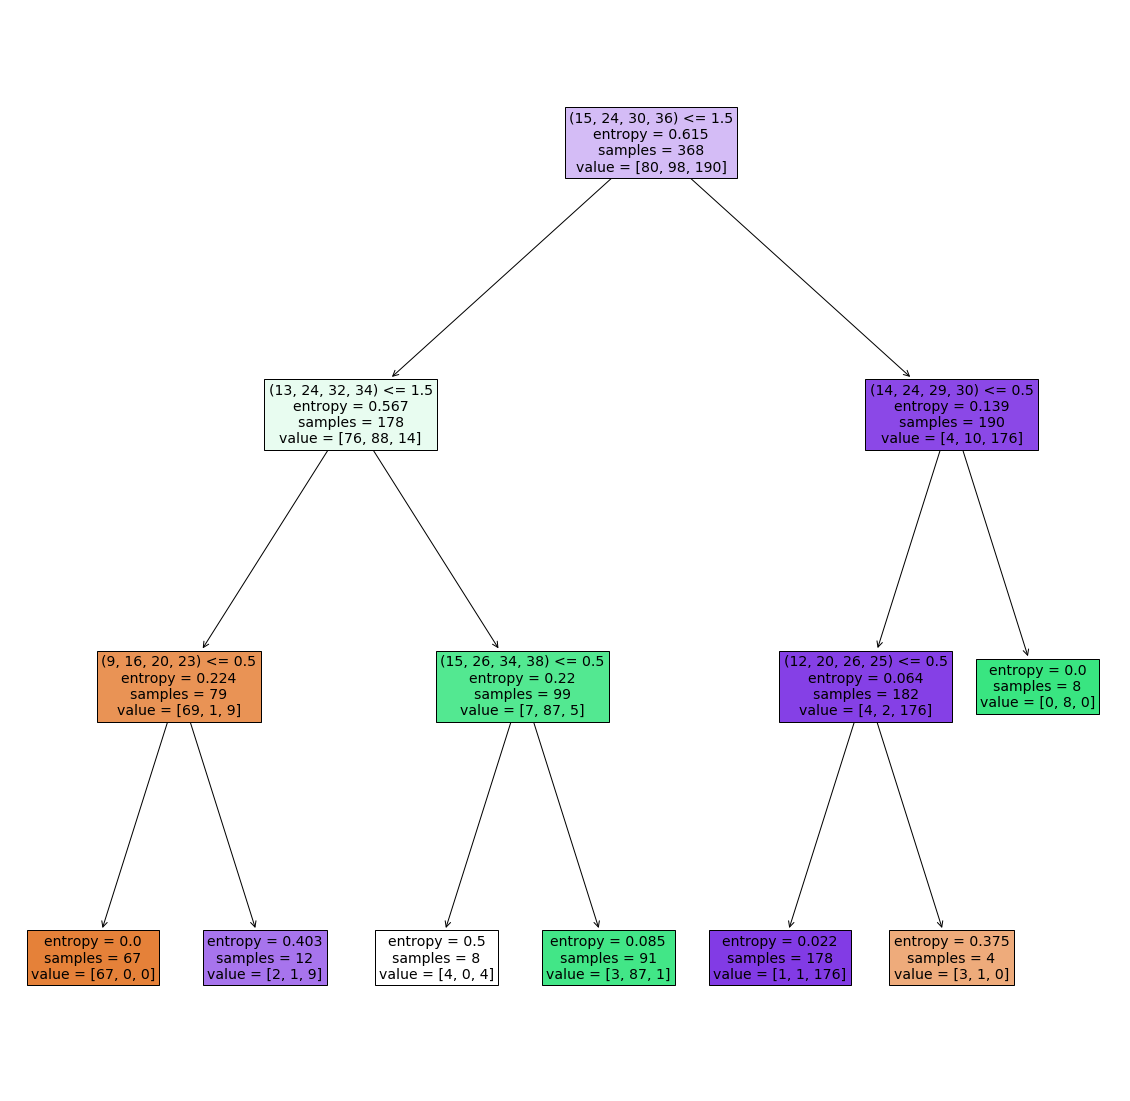

In [7]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(1, figsize=(20,20))
plot_tree(clf, filled=True, ax=ax, feature_names=train_embedder.kmer_shape_keys + train_embedder.radius_shape_keys);

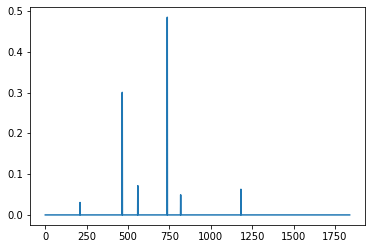

In [8]:
plt.plot(clf.feature_importances_)
predictive_feature_indices = np.argsort(clf.feature_importances_)[::-1][:6]

In [10]:
shapemer = train_embedder.map_shapemer_index_to_shapemer(predictive_feature_indices[2])
residue_indices_train = train_embedder.map_shapemer_index_to_residues(predictive_feature_indices[2])
print(shapemer, len(residue_indices_train))
print(residue_indices_train)

(14, 24, 29, 30) 12
defaultdict(<class 'set'>, {('4ic7', 'D'): {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}, ('4ic7', 'A'): {144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159}, ('5byz', 'A'): {142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157}, ('5bve', 'A'): {160, 161, 162, 163, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159}, ('6hkm', 'A'): {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 125, 126, 127}, ('4fmq', 'A'): {160, 161, 162, 163, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159}, ('4zsj', 'A'): {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155}, ('4zsg', 'A'): {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}, ('4zsl', 'A'): {137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152}, ('5byy', 'A'): {141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153

The residue indices for each protein calculated above can then be visualized on the protein structure using software such as PyMol.

